# Course 4 : Exercise 4 : Sunspots

This week you moved away from synthetic data to do a real-world prediction -- sunspots. You loaded data from CSV and built models to use it. For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

In [49]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [50]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value") 
    plt.grid(True)

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

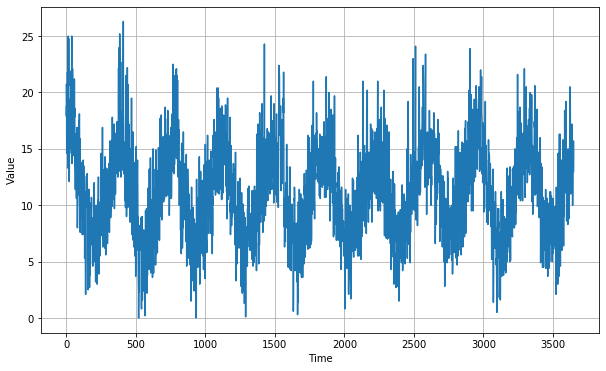

In [51]:
import csv
time_step = []
temps = []

with open('source/daily-min-temperatures.csv') as csvfile:
    # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [52]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [53]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [54]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv1D(filters = 32,
                          kernel_size = 5,
                          strides = 1,
                          padding = "causal",
                          activation = "relu",
                          input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

[1e-08, 0.0001, 0, 60]

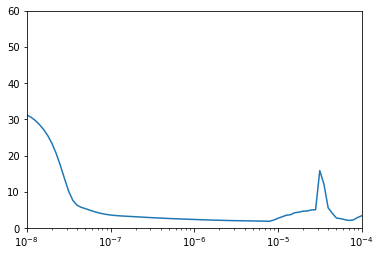

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum = 0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

In [58]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

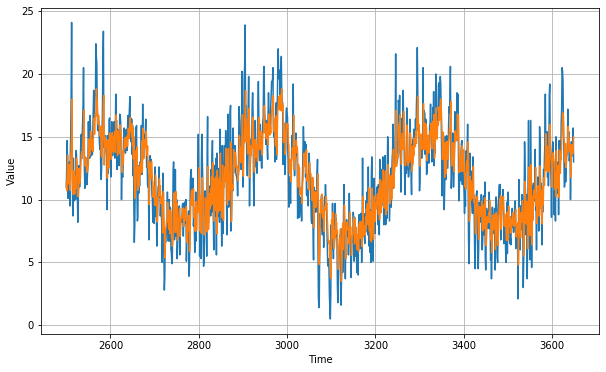

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [60]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796255

In [61]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.327806 10.704856 12.123924 ... 13.603828 13.795918 15.008247]
